# **Simple Black-box Adversarial Attack (SimBA) and Pre-processing Defenses Using CIFAR-10**

This notebook demonstrates the implementation of the Simple Black-box Attack (SimBA) using the Adversarial Robustness Toolbox (ART) against deep learning models trained on the CIFAR-10 dataset. The tasks covered include:

1. Load the Required Libraries: Import necessary Python libraries and modules, including TensorFlow/Keras and ART.

2. Load the Dataset and Inspect the Data: Load and visualize the CIFAR-10 dataset, which consists of 60,000 32x32 color images in 10 classes.

3. Load the Pretrained Deep Learning Model: Load a pre-trained deep learning model, such as ResNet-18, for classifying CIFAR-10 images.

4. Evaluate the Deep Learning Model on CIFAR-10 Test Data: Assess the baseline accuracy of the model on the test dataset to establish a performance benchmark.

5. Create an ART Keras Classifier: Wrap the pre-trained model with an ART Keras classifier to facilitate adversarial attack implementations.

6. **Implement SimBA Attack Using ART**:
    * Simple Black-box Attack (SimBA): An efficient black-box adversarial attack that perturbs images by iteratively flipping the sign of individual pixels and checking the impact on the model's prediction.
        * **Random Pixel Selection**: Choosing random pixels to perturb in the input image.
        * **Sign Flip**: Flipping the sign of the selected pixel values to create perturbations.
        * **Querying the Model**: Evaluating the impact of each perturbation by querying the model and measuring the change in its output.
        * **Iterative Process**: Repeating the process iteratively to maximize the attack's success in causing misclassification with minimal perturbations.

7. Create Adversarial Samples Using the SimBA Attack: Generate adversarial examples from the test images using SimBA and visually inspect them.

8. Evaluate the Deep Learning Model Against the Adversarial Samples: Test the model's robustness by evaluating its accuracy on the generated adversarial samples.

9. Split the Successful Adversarial Samples from Unsuccessful Ones: Separate the adversarial examples that successfully fooled the model from those that did not.

10. Implement Pre-processing Defenses:
    * Feature Squeezing: Reduce the precision of input features to limit the space for adversarial perturbations, making it harder for adversarial examples to be effective.
    * JPEG Compression: Re-encode images using JPEG compression to remove high-frequency noise and reduce the impact of small perturbations.
    * Total Variance Minimization: Reduce the total variation in the image to suppress adversarial perturbations, which typically introduce high-frequency noise.
    * Spatial Smoothing: Apply smoothing filters (e.g., Gaussian blur) to input images to mitigate adversarial perturbations by averaging pixel values over local neighborhoods.

    Evaluate the Model on Adversarial Pre-processed Clean Data: Assess the model's accuracy on the adversarial examples after applying the pre-processing defenses to determine their effectiveness in mitigating the impact of adversarial attacks.

## 1. Install and import required Libraries

In [ ]:
# !pip install adversarial-robustness-toolbox

In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import numpy as np
from matplotlib import pyplot as plt

from art.utils import load_cifar10, preprocess, to_categorical

from art.estimators.classification import KerasClassifier
from art.attacks.evasion import SimBA
from art.defences.preprocessor import FeatureSqueezing
from art.defences.preprocessor import JpegCompression
from art.defences.preprocessor import TotalVarMin
from art.defences.preprocessor import SpatialSmoothing

2024-06-12 11:09:59.238078: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-12 11:09:59.335114: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


### 2. Load the Dataset and Inspect the Data

In [2]:
# (x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()
# Load the dataset from the local drive
data = np.load('./../datasets/cifar10_dataset.npz')
x_train, y_train, x_test, y_test= data['X_train'], data['y_train'], data['X_test'], data['y_test']

class_name = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

min = x_train.min()
max = x_train.max()

x_train.shape, y_train.shape, x_test.shape, y_test.shape, min, max

((50000, 32, 32, 3), (50000, 10), (10000, 32, 32, 3), (10000, 10), 0.0, 1.0)

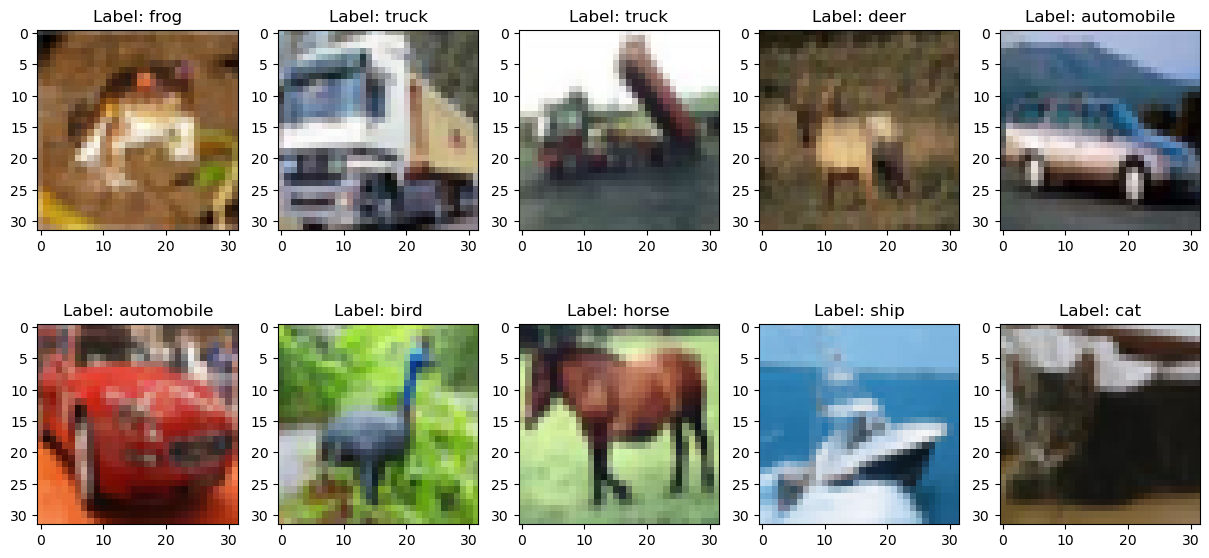

In [4]:
fig, ax = plt.subplots(2,5, figsize=(15, 7))
ax = ax.flatten()

for i, (image, label) in enumerate(zip(x_train[:10], y_train[:10])):
  ax[i].imshow(image)
  ax[i].set_title(f"Label: {class_name[label.argmax()]}",  fontsize=12)

### 3. Load the Pretrained Deep Learning Model

In [3]:
model = tf.keras.models.load_model('./../models/cifar10_cnn.keras')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.


2024-06-12 11:10:07.091254: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-12 11:10:07.301922: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22901 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:17:00.0, compute capability: 7.5
2024-06-12 11:10:07.302703: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 45419 MB memory:  -> device: 1, name: Quadro RTX 8000, pci bus id: 0000:73:00.0, compute capability: 7.5
2024-06-12 11:10:07.330749: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimizati

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_17 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 batch_normalization_8 (Batc  (None, 16, 16, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_18 (Conv2D)          (None, 16, 16, 64)       

### 4. Evaluate the Deep Learning Model on MNIST-10 Test Data

In [4]:
loss_test, accuracy_test = model.evaluate(x_test, y_test)
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

2024-06-12 11:10:11.731703: W tensorflow/c/c_api.cc:291] Operation '{name:'loss/mul' id:745 op device:{requested: '', assigned: ''} def:{{{node loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul/x, loss/dense_8_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-06-12 11:10:11.821769: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indropout_12/cond/then/_0/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-06-12 11:10:11.926311: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8902


Accuracy on test data: 85.26%


### 5. Create an ART Keras Classifier:

In [5]:
classifier = KerasClassifier(model=model, clip_values=(min, max))

### Create an ART SimBA attack.

In [6]:
simba_attack = SimBA(classifier = classifier,
              attack = 'dct',
              max_iter = 1000,
              order = 'random',
               epsilon = 0.1,
               freq_dim = 4,
               stride = 1,
               targeted = False,
               batch_size = 1,
               verbose = False)

#### Import Adversarial genereated Samples using PGD from workshop2

In [7]:
# x_test = x_test[:200]
# y_test = y_test[:200]
# x_test_adv = simba_attack.generate(x_test, y=y_test)

adv_data = np.load('../workshop3/SimBA_data/SimBA_cifar-10_generated_data.npz')
x_test_adv, y_test = adv_data['x_test_adv'], adv_data['y_test']
x_test_adv.shape, y_test.shape

((200, 32, 32, 3), (200, 10))

2024-06-12 11:10:21.258501: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_8/Softmax' id:516 op device:{requested: '', assigned: ''} def:{{{node dense_8/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_8/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-06-12 11:10:21.366119: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indropout_12/cond/then/_0/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


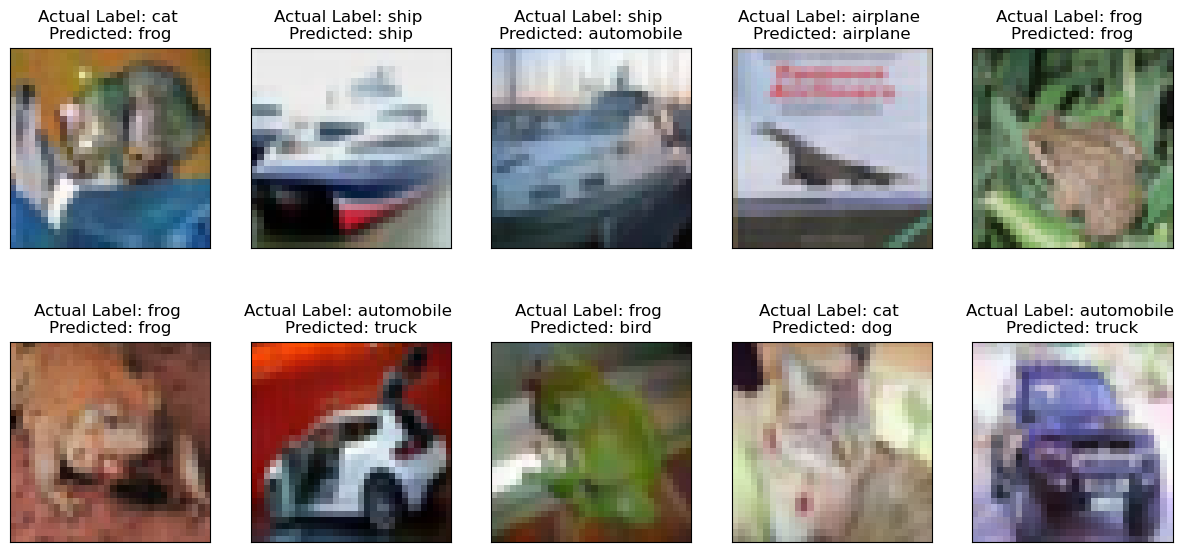

In [8]:
fig, ax = plt.subplots(2,5, figsize=(15, 7))
ax = ax.flatten()

for i, (image, label) in enumerate(zip(x_test_adv[:10], y_test[:10])):
  ax[i].set_xticks([])
  ax[i].set_yticks([])
  ax[i].imshow(image)
  ax[i].set_title(f"Actual Label: {class_name[label.argmax()]} \nPredicted: {class_name[model.predict(np.expand_dims(image, axis=0)).argmax()]}",  fontsize=12)

In [9]:
loss_test, accuracy_test = model.evaluate(x_test_adv, y_test)
perturbation = np.mean(np.abs((x_test_adv - x_test[:200])))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))

Accuracy on adversarial test data: 47.00%
Average perturbation: 0.01


### 9. Split the Successful Adversarial Samples from Unsuccessful Ones:

In [10]:
# Make predictions on the test set
predictions = model.predict(x_test_adv)
predicted_labels = np.argmax(predictions, axis=1)
predicted_labels[:10]

# Separate correctly and incorrectly classified samples
correct_indices = np.where(predicted_labels == np.argmax(y_test, axis = 1))
incorrect_indices = np.where(predicted_labels != np.argmax(y_test, axis = 1))

x_test_adv_success = x_test_adv[incorrect_indices]
y_test_adv_success = y_test[incorrect_indices]
x_test_adv_failure = x_test_adv[correct_indices]
y_test_adv_failure = y_test[correct_indices]

print('Number of successful and unsucessful adversarial samples')
print(f'Number of successful adversarail samples : {x_test_adv_success.shape[0]}')
print(f'Number of failure adversarail samples : {x_test_adv_failure.shape[0]}')

Number of successful and unsucessful adversarial samples
Number of successful adversarail samples : 106
Number of failure adversarail samples : 94


#### Evaluate the succesful adversarail samples. 

In [11]:
loss_test, accuracy_test = model.evaluate(x_test_adv_success, y_test_adv_success)
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy on test data: 0.00%


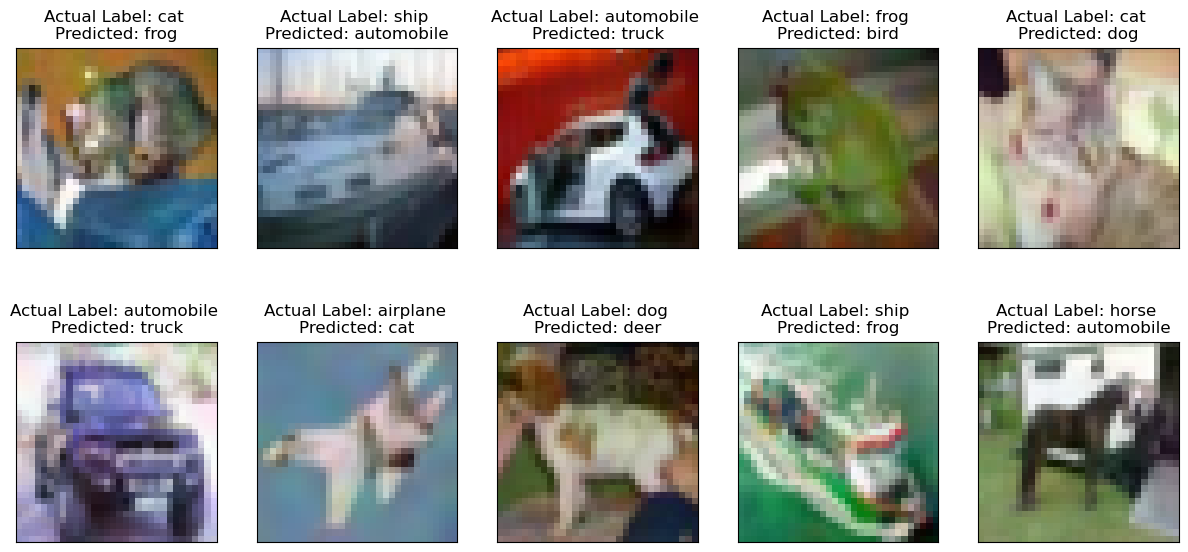

In [12]:
fig, ax = plt.subplots(2,5, figsize=(15, 7))
ax = ax.flatten()

for i, (image, label) in enumerate(zip(x_test_adv_success[:10], y_test_adv_success[:10])):
  ax[i].set_xticks([])
  ax[i].set_yticks([])
  ax[i].imshow(image)
  ax[i].set_title(f"Actual Label: {class_name[label.argmax()]} \nPredicted: {class_name[model.predict(np.expand_dims(image, axis=0)).argmax()]}",  fontsize=12)

#### Evaluate the unsuccesful adversarail samples.

In [13]:
loss_test, accuracy_test = model.evaluate(x_test_adv_failure, y_test_adv_failure)
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy on test data: 100.00%


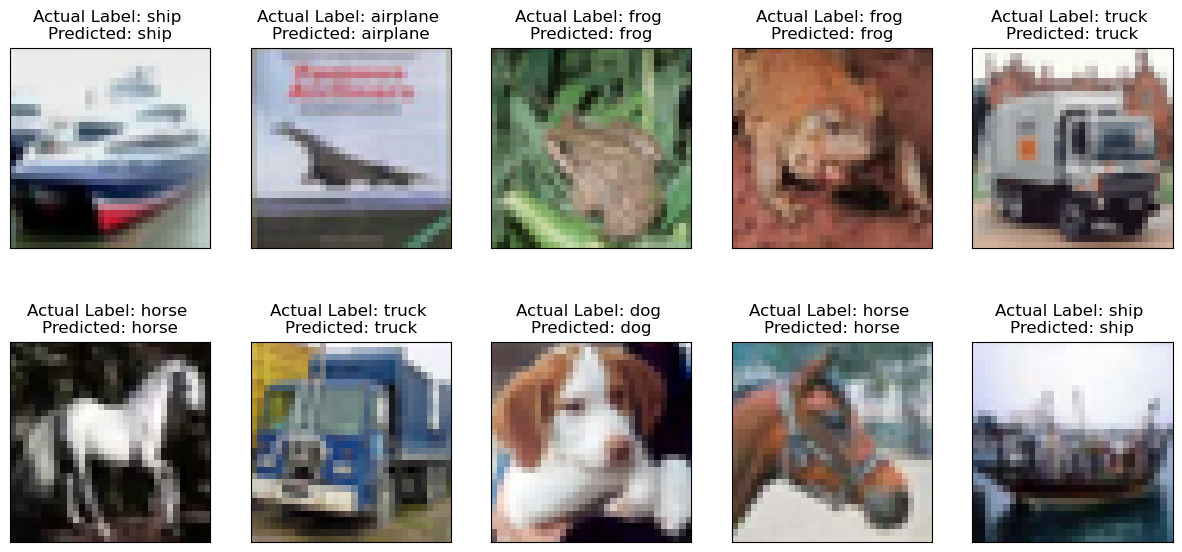

In [14]:
fig, ax = plt.subplots(2,5, figsize=(15, 7))
ax = ax.flatten()

for i, (image, label) in enumerate(zip(x_test_adv_failure[:10], y_test_adv_failure[:10])):
  ax[i].set_xticks([])
  ax[i].set_yticks([])
  ax[i].imshow(image)
  ax[i].set_title(f"Actual Label: {class_name[label.argmax()]} \nPredicted: {class_name[model.predict(np.expand_dims(image, axis=0)).argmax()]}",  fontsize=12)

## 10. Implement Pre-processing Defenses:

### 10.1 Implemeting Feature Squeezing: 


*class art.defences.preprocessor.FeatureSqueezing(clip_values: Tuple[int | float | ndarray, int | float | ndarray], bit_depth: int = 8, apply_fit: bool = False, apply_predict: bool = True)*

* Reduces the sensibility of the features of a sample
* Paper link: https://arxiv.org/abs/1704.01155
* Please keep in mind the limitations of defences. For more information on the limitations of this defence, see https://arxiv.org/abs/1803.09868 . For details on how to evaluate classifier security in general, see https://arxiv.org/abs/1902.06705

**__call__(x: ndarray, y: ndarray | None = None) → Tuple[ndarray, ndarray | None]**

Apply feature squeezing to sample x.

        Parameters:

* x (ndarray) – Sample to squeeze. x values are expected to be in the data range provided by clip_values.

* y – Labels of the sample x. This function does not affect them in any way.

        Returns:

* Squeezed sample.

**__init__(clip_values: Tuple[int | float | ndarray, int | float | ndarray], bit_depth: int = 8, apply_fit: bool = False, apply_predict: bool = True) → None**

Create an instance of feature squeezing.

        Parameters:

* clip_values – Tuple of the form (min, max) representing the minimum and maximum values allowed for features.

* bit_depth (int) – The number of bits per channel for encoding the data.

* apply_fit (bool) – True if applied during fitting/training.

* apply_predict (bool) – True if applied during predicting.



In [24]:
feature_squeezing = FeatureSqueezing(clip_values=(0.0, 1.0), 
                                     bit_depth=5, 
                                     apply_fit=False, 
                                     apply_predict=True)

#### 10.1.1 Implying **Feature Squeezing** on adversarial successful data

In [25]:
fs_success_data, fs_success_labels = feature_squeezing(x_test_adv_success, y_test_adv_success)

In [26]:
loss_test, accuracy_test = model.evaluate(fs_success_data, fs_success_labels)
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy on test data: 52.83%


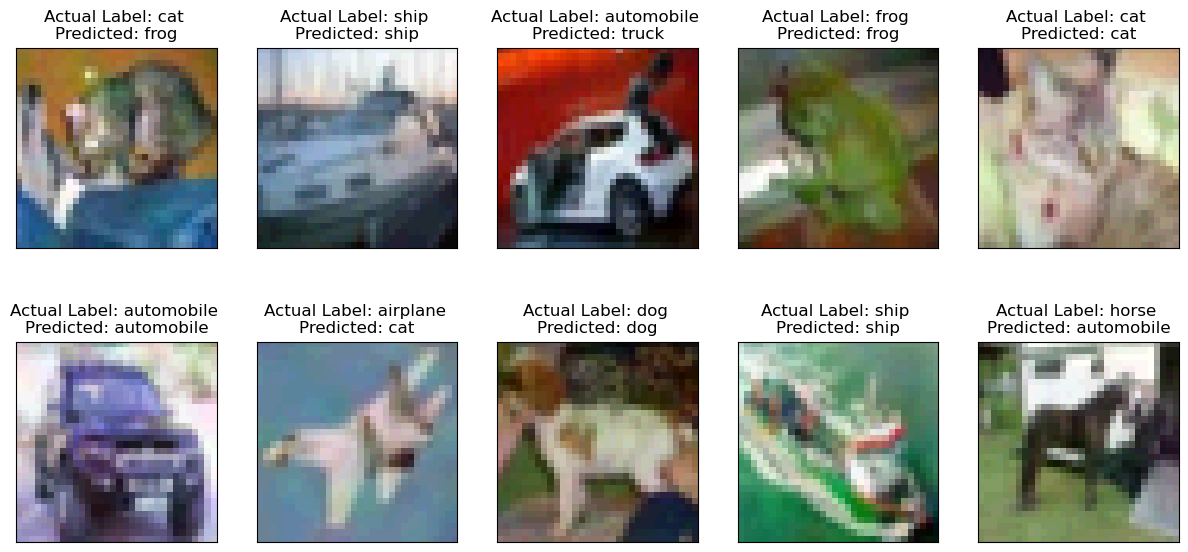

In [41]:
fig, ax = plt.subplots(2,5, figsize=(15, 7))
ax = ax.flatten()

for i, (image, label) in enumerate(zip(fs_success_data[:10], fs_success_labels[:10])):
  ax[i].set_xticks([])
  ax[i].set_yticks([])
  ax[i].imshow(image)
  ax[i].set_title(f"Actual Label: {class_name[label.argmax()]} \nPredicted: {class_name[model.predict(np.expand_dims(image, axis=0)).argmax()]}",  fontsize=12)

#### 10.1.1 Implying **Feature Squeezing** on adversarial unsuccessful data

In [27]:
fs_failure_data, fs_failure_labels = feature_squeezing(x_test_adv_failure, y_test_adv_failure)

In [28]:
loss_test, accuracy_test = model.evaluate(fs_failure_data, fs_failure_labels)
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy on test data: 100.00%


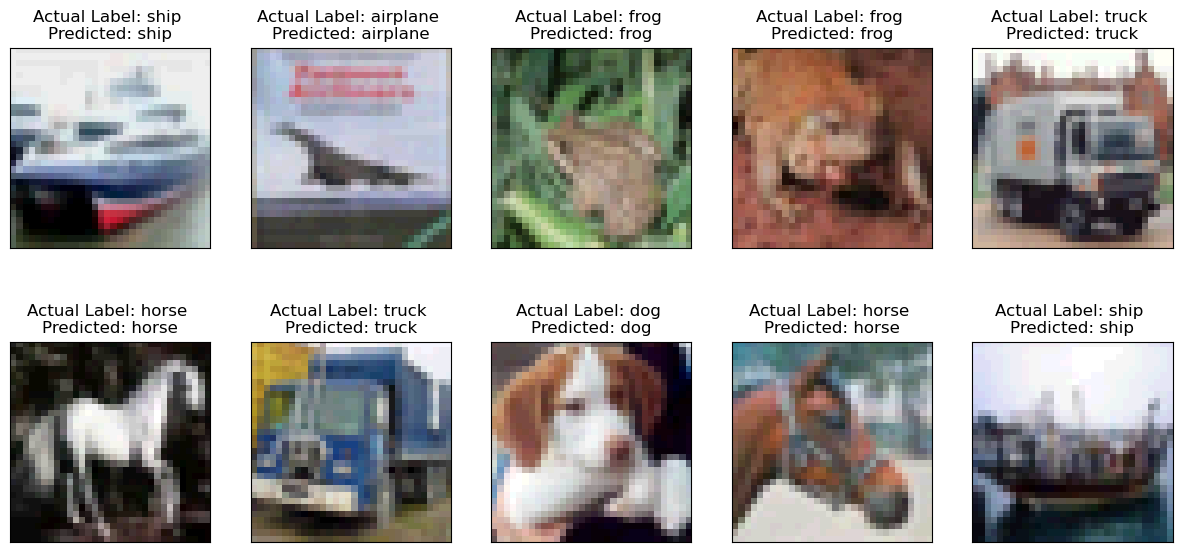

In [29]:
fig, ax = plt.subplots(2,5, figsize=(15, 7))
ax = ax.flatten()

for i, (image, label) in enumerate(zip(fs_failure_data[:10], fs_failure_labels[:10])):
  ax[i].set_xticks([])
  ax[i].set_yticks([])
  ax[i].imshow(image)
  ax[i].set_title(f"Actual Label: {class_name[label.argmax()]} \nPredicted: {class_name[model.predict(np.expand_dims(image, axis=0)).argmax()]}",  fontsize=12)

### 10.2 Implemeting JPEG Compression: 


*class art.defences.preprocessor.JpegCompression(clip_values: CLIP_VALUES_TYPE, quality: int = 50, channels_first: bool = False, apply_fit: bool = True, apply_predict: bool = True, verbose: bool = False)*

* Implement the JPEG compression defence approach.

* For input images or videos with 3 color channels the compression is applied in mode RGB (3x8-bit pixels, true color), for all other numbers of channels the compression is applied for each channel with mode L (8-bit pixels, black and white).
* Paper link: https://arxiv.org/abs/1705.02900, https://arxiv.org/abs/1608.00853
* Please keep in mind the limitations of defences. For more information on the limitations of this defence, see https://arxiv.org/abs/1802.00420 . For details on how to evaluate classifier security in general, see https://arxiv.org/abs/1902.06705

**__call__(x: ndarray, y: ndarray | None = None) → Tuple[ndarray, ndarray | None]**

Apply JPEG compression to sample x.

For input images or videos with 3 color channels the compression is applied in mode RGB (3x8-bit pixels, true color), for all other numbers of channels the compression is applied for each channel with mode L (8-bit pixels, black and white).

    Parameters:

* x (ndarray) – Sample to compress with shape of NCHW, NHWC, NCFHW or NFHWC. x values are expected to be in the data range [0, 1] or [0, 255].

* y – Labels of the sample x. This function does not affect them in any way.

    Returns:

* compressed sample.

**__init__(clip_values: CLIP_VALUES_TYPE, quality: int = 50, channels_first: bool = False, apply_fit: bool = True, apply_predict: bool = True, verbose: bool = False)**

Create an instance of JPEG compression.

    Parameters:

* clip_values – Tuple of the form (min, max) representing the minimum and maximum values allowed for features.

* quality (int) – The image quality, on a scale from 1 (worst) to 95 (best). Values above 95 should be avoided.

* channels_first (bool) – Set channels first or last.

* apply_fit (bool) – True if applied during fitting/training.

* apply_predict (bool) – True if applied during predicting.

* verbose (bool) – Show progress bars.



In [31]:
jpeg_pixel = JpegCompression(clip_values=(0.0, 1.0),
                        quality = 40,
                        channels_first=False, 
                        apply_fit = False, 
                        apply_predict = True,
                        verbose = True)

#### 10.2.1 Implying **JPEG Compression** on adversarial successful data

In [32]:
jpegp_success_data, jpegp_success_labels = jpeg_pixel(x_test_adv_success, y_test_adv_success)

JPEG compression: 0it [00:00, ?it/s]

In [33]:
loss_test, accuracy_test = model.evaluate(jpegp_success_data, jpegp_success_labels)
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy on test data: 47.17%


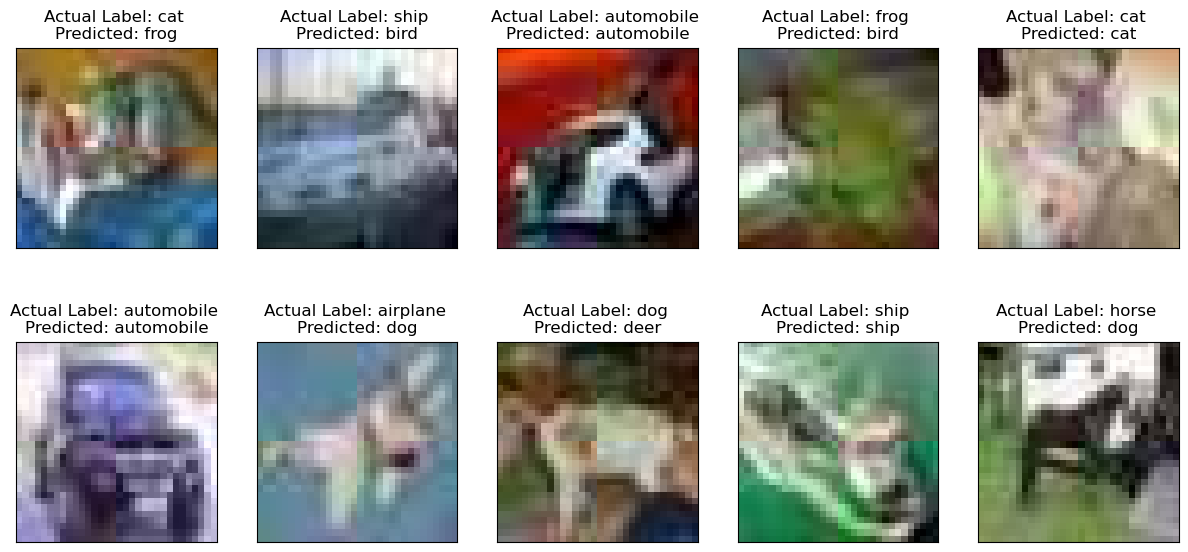

In [34]:
fig, ax = plt.subplots(2,5, figsize=(15, 7))
ax = ax.flatten()

for i, (image, label) in enumerate(zip(jpegp_success_data[:10], jpegp_success_labels[:10])):
  ax[i].set_xticks([])
  ax[i].set_yticks([])
  ax[i].imshow(image)
  ax[i].set_title(f"Actual Label: {class_name[label.argmax()]} \nPredicted: {class_name[model.predict(np.expand_dims(image, axis=0)).argmax()]}",  fontsize=12)

#### 10.2.2 Implying **JPEG Compression** on adversarial unsuccessful data

In [35]:
fs_failure_data, fs_failure_labels = jpeg_pixel(x_test_adv_failure, y_test_adv_failure)

JPEG compression: 0it [00:00, ?it/s]

In [36]:
loss_test, accuracy_test = model.evaluate(fs_failure_data, fs_failure_labels)
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy on test data: 96.81%


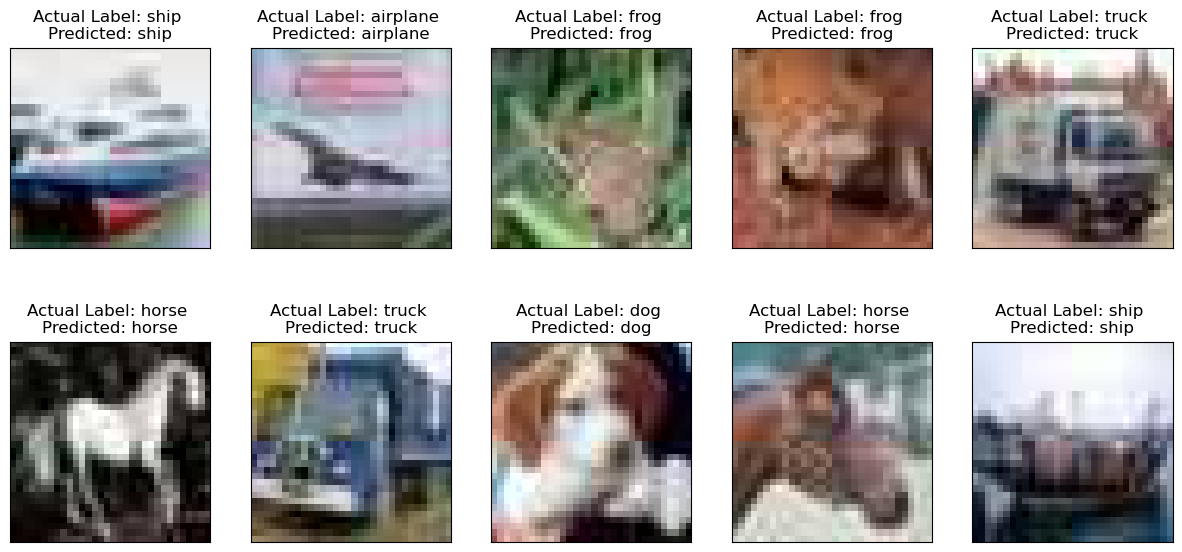

In [37]:
fig, ax = plt.subplots(2,5, figsize=(15, 7))
ax = ax.flatten()

for i, (image, label) in enumerate(zip(fs_failure_data[:10], fs_failure_labels[:10])):
  ax[i].set_xticks([])
  ax[i].set_yticks([])
  ax[i].imshow(image)
  ax[i].set_title(f"Actual Label: {class_name[label.argmax()]} \nPredicted: {class_name[model.predict(np.expand_dims(image, axis=0)).argmax()]}",  fontsize=12)

### 10. 3 Implementing Total Variance Minimization:

*class art.defences.preprocessor.TotalVarMin(prob: float = 0.3, norm: int = 2, lamb: float = 0.5, solver: str = 'L-BFGS-B', max_iter: int = 10, clip_values: CLIP_VALUES_TYPE | None = None, apply_fit: bool = False, apply_predict: bool = True, verbose: bool = False)*

* Implement the total variance minimization defence approach.
* Paper link: https://openreview.net/forum?id=SyJ7ClWCb
* Please keep in mind the limitations of defences. For more information on the limitations of this defence, see https://arxiv.org/abs/1802.00420 . For details on how to evaluate classifier security in general, see https://arxiv.org/abs/1902.06705

**__call__(x: ndarray, y: ndarray | None = None) → Tuple[ndarray, ndarray | None]**

Apply total variance minimization to sample x.

    Parameters:

* x (ndarray) – Sample to compress with shape (batch_size, width, height, depth).

* y – Labels of the sample x. This function does not affect them in any way.

    Returns:

* Similar samples.

*__init__(prob: float = 0.3, norm: int = 2, lamb: float = 0.5, solver: str = 'L-BFGS-B', max_iter: int = 10, clip_values: CLIP_VALUES_TYPE | None = None, apply_fit: bool = False, apply_predict: bool = True, verbose: bool = False)*

Create an instance of total variance minimization.

    Parameters:

* prob (float) – Probability of the Bernoulli distribution.

* norm (int) – The norm (positive integer).

* lamb (float) – The lambda parameter in the objective function.

* solver (str) – Current support: L-BFGS-B, CG, Newton-CG.

* max_iter (int) – Maximum number of iterations when performing optimization.

* clip_values – Tuple of the form (min, max) representing the minimum and maximum values allowed for features.

* apply_fit (bool) – True if applied during fitting/training.

* apply_predict (bool) – True if applied during predicting.

* verbose (bool) – Show progress bars.

In [38]:
total_var_min = TotalVarMin(prob = 0.3,
                            norm = 1, 
                            lamb = 0.1, 
                            solver = "L-BFGS-B",
                            max_iter = 10, 
                            clip_values = None, 
                            apply_fit = False,
                            apply_predict = True, 
                            verbose = True)

#### 10.3.1 Implying **Total Variance Minimization** on adversarial successful data

In [39]:
pd_success_data, pd_success_labels = total_var_min(x_test_adv_success, y_test_adv_success)

Variance minimization:   0%|          | 0/106 [00:00<?, ?it/s]

In [41]:
loss_test, accuracy_test = model.evaluate(pd_success_data, pd_success_labels)
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy on test data: 34.91%


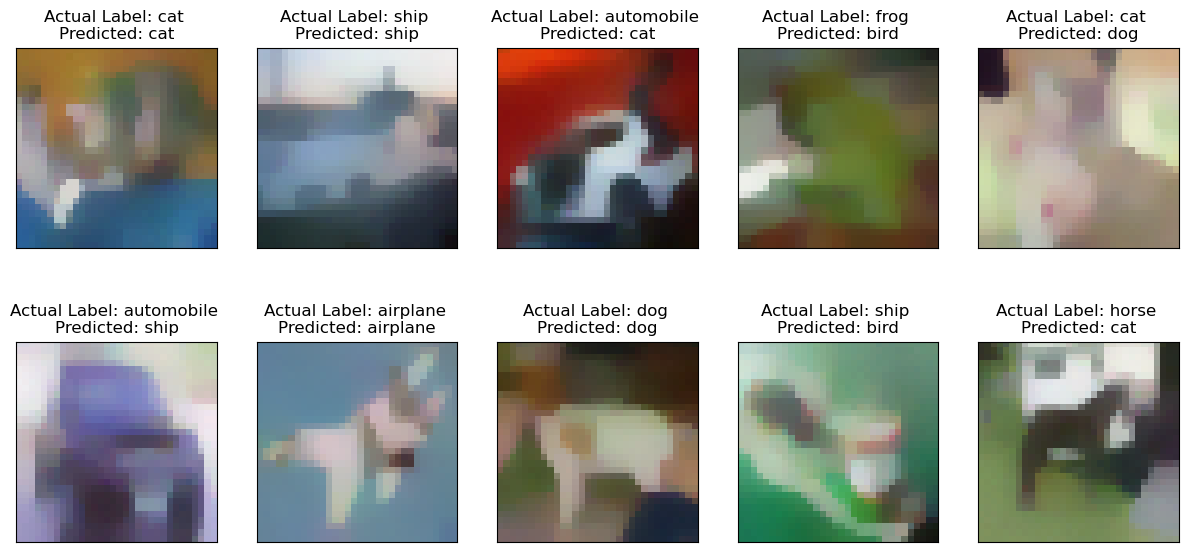

In [42]:
fig, ax = plt.subplots(2,5, figsize=(15, 7))
ax = ax.flatten()

for i, (image, label) in enumerate(zip(pd_success_data[:10], pd_success_labels[:10])):
  ax[i].set_xticks([])
  ax[i].set_yticks([])
  ax[i].imshow(image)
  ax[i].set_title(f"Actual Label: {class_name[label.argmax()]} \nPredicted: {class_name[model.predict(np.expand_dims(image, axis=0)).argmax()]}",  fontsize=12)

#### 10.3.2 Implying **Total Variance Minimization** on adversarial unsuccessful data

In [43]:
fs_failure_data, fs_failure_labels = total_var_min(x_test_adv_failure, y_test_adv_failure)

Variance minimization:   0%|          | 0/94 [00:00<?, ?it/s]

In [44]:
loss_test, accuracy_test = model.evaluate(fs_failure_data, fs_failure_labels)
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy on test data: 72.34%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


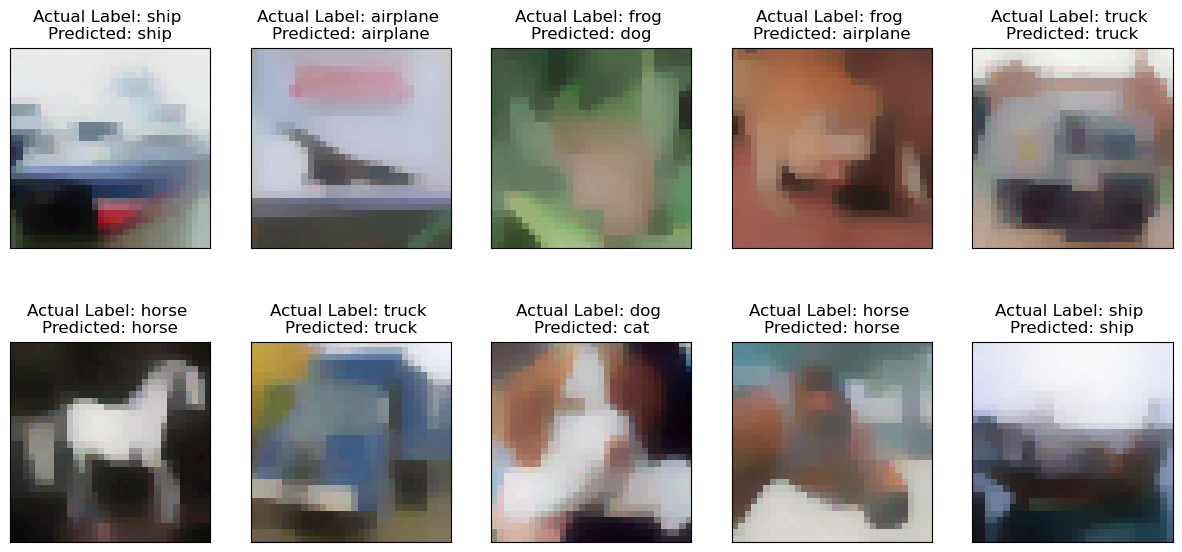

In [45]:
fig, ax = plt.subplots(2,5, figsize=(15, 7))
ax = ax.flatten()

for i, (image, label) in enumerate(zip(fs_failure_data[:10], fs_failure_labels[:10])):
  ax[i].set_xticks([])
  ax[i].set_yticks([])
  ax[i].imshow(image)
  ax[i].set_title(f"Actual Label: {class_name[label.argmax()]} \nPredicted: {class_name[model.predict(np.expand_dims(image, axis=0)).argmax()]}",  fontsize=12)

### 10.4 Implementing Spatial Smoothing:


*class art.defences.preprocessor.SpatialSmoothing(window_size: int = 3, channels_first: bool = False, clip_values: Tuple[int | float | ndarray, int | float | ndarray] | None = None, apply_fit: bool = False, apply_predict: bool = True)*

* Implement the local spatial smoothing defence approach.
* Paper link: https://arxiv.org/abs/1704.01155
* Please keep in mind the limitations of defences. For more information on the limitations of this defence, see https://arxiv.org/abs/1803.09868 . For details on how to evaluate classifier security in general, see https://arxiv.org/abs/1902.06705

**__call__(x: ndarray, y: ndarray | None = None) → Tuple[ndarray, ndarray | None]**

Apply local spatial smoothing to sample x.

    Parameters:

* x (ndarray) – Sample to smooth with shape (batch_size, width, height, depth).

* y – Labels of the sample x. This function does not affect them in any way.

    Returns:

* Smoothed sample.

**__init__(window_size: int = 3, channels_first: bool = False, clip_values: Tuple[int | float | ndarray, int | float | ndarray] | None = None, apply_fit: bool = False, apply_predict: bool = True) → None**

Create an instance of local spatial smoothing.

    Parameters:

* channels_first (bool) – Set channels first or last.

* window_size (int) – The size of the sliding window.

* clip_values – Tuple of the form (min, max) representing the minimum and maximum values allowed for features.

* apply_fit (bool) – True if applied during fitting/training.

* apply_predict (bool) – True if applied during predicting.



In [46]:
spatial_smoothing = SpatialSmoothing(window_size= 2, 
                                     channels_first = False, 
                                     clip_values = (0.0, 1.0),
                                     apply_fit = False,
                                     apply_predict = True)

#### 10.4.1 Implying **Spatial Smoothing** on adversarial successful data

In [47]:
ss_success_data, ss_success_labels = spatial_smoothing(x_test_adv_success, y_test_adv_success)

In [48]:
loss_test, accuracy_test = model.evaluate(ss_success_data, ss_success_labels)
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy on test data: 44.34%


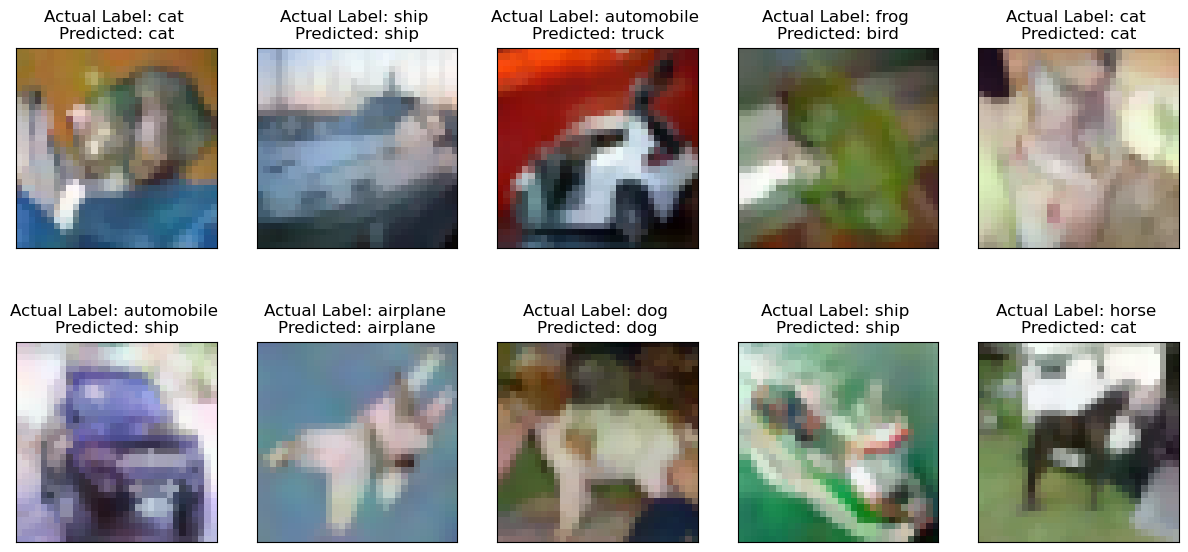

In [49]:
fig, ax = plt.subplots(2,5, figsize=(15, 7))
ax = ax.flatten()

for i, (image, label) in enumerate(zip(ss_success_data[:10], ss_success_labels[:10])):
  ax[i].set_xticks([])
  ax[i].set_yticks([])
  ax[i].imshow(image)
  ax[i].set_title(f"Actual Label: {class_name[label.argmax()]} \nPredicted: {class_name[model.predict(np.expand_dims(image, axis=0)).argmax()]}",  fontsize=12)

#### 10.4.2 Implying **Spatial Smoothing** on adversarial unsuccessful data

In [50]:
ss_failure_data, ss_failure_labels = spatial_smoothing(x_test_adv_failure, y_test_adv_failure)

In [51]:
loss_test, accuracy_test = model.evaluate(ss_failure_data, ss_failure_labels)
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy on test data: 96.81%


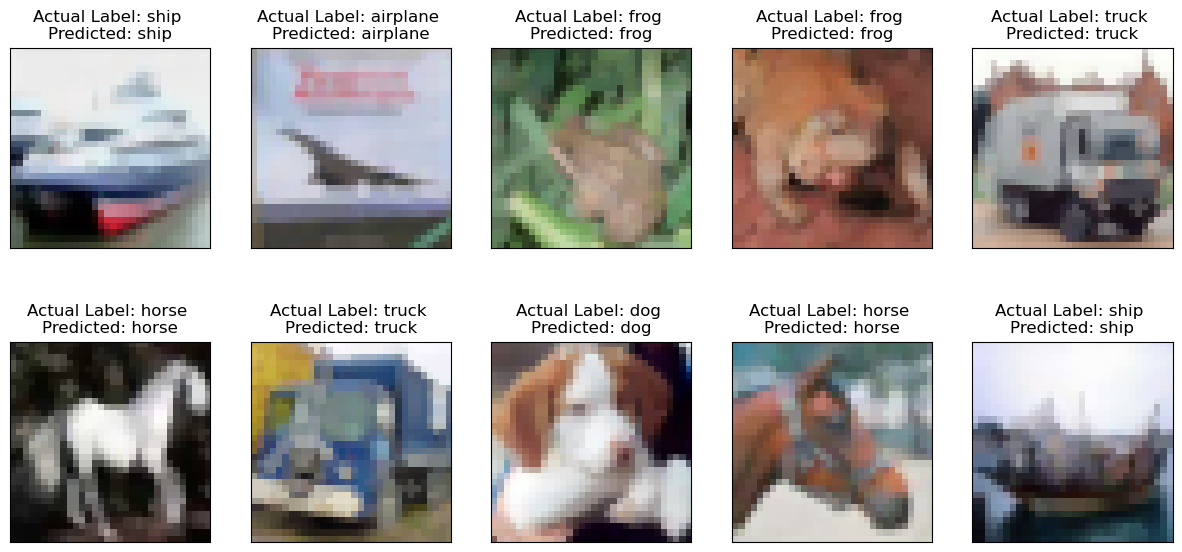

In [52]:
fig, ax = plt.subplots(2,5, figsize=(15, 7))
ax = ax.flatten()

for i, (image, label) in enumerate(zip(ss_failure_data[:10], ss_failure_labels[:10])):
  ax[i].set_xticks([])
  ax[i].set_yticks([])
  ax[i].imshow(image)
  ax[i].set_title(f"Actual Label: {class_name[label.argmax()]} \nPredicted: {class_name[model.predict(np.expand_dims(image, axis=0)).argmax()]}",  fontsize=12)

#### Summary: 
In this notebook, we implement the SimBA attack on the CIFAR-10 dataset. We generate adversarial samples and evaluate the model's accuracy to determine how many samples successfully fooled the model. We then split the data into successful adversarial samples and benign samples. Both datasets are passed through the following defenses:  **feature squeezing**, **JPEG compression**, **Total Variance Minimization**, and **Spacial Smoothing**. Finally, we evaluate the model on the processed datasets to assess the impact of these pre-processing defenses on both the successful adversarial samples and the benign samples.